In [3]:
"""
This module implements the Lowess function for nonparametric regression.
Functions:
lowess Fit a smooth nonparametric regression curve to a scatterplot.
For more information, see
William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.
William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.
"""

# Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

from math import ceil
import numpy as np
from scipy import linalg


def lowess(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest



In [58]:
def wgted_median(x,wgts): 
    weights = wgts/np.sum(wgts)
    left = 0
    right = len(x)-1
    n = len(x)
    if n != len(weights):
        raise  Exception('Lengths dont match, wgts: {0} , x: {1} !'.format(n,len(weights)))
    if n <3:
        return np.mean(x)
    while(left <= right):
        mid = (left+right)//2
        split = np.argpartition(x, mid)
        left_wgt = np.sum( weights[split[0:mid]])
        right_wgt = np.sum( weights[split[mid+1:]])
        if np.around(left_wgt,3) <= 0.5 and  np.around(right_wgt,3) <=0.5:
            if n%2 == 1 :
                return x[split[mid]]
            else:
                if left_wgt >= right_wgt:
                    return 0.5*(x[ split[ mid-1]] + x[split[ mid]] ) 
                else:
                    split = np.argpartition(x, mid+1)
                    return 0.5*(x[ split[ mid+1]] + x[split[ mid]] ) 
                
        elif left_wgt > 0.5:
            right = mid-1
        else:
            left = mid+1

def repeated_wgt_median(x,y, f=2. / 3.):    
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    #Tricube
    w = (70.0*(1 - np.abs(w) ** 3)**3)/81
    #w = (3.0*(1 - np.abs(w) ** 2))/4
    ys = np.zeros(n)
    slopes = np.zeros(n)
    mus=[]
    for i in range(n):
        wgts = w[:,i]
        y_i = y[np.nonzero(wgts)]
        x_i = x[np.nonzero(wgts)]
        wgts = wgts[np.nonzero(wgts)]
        wgted_slopes = []
        mask = np.ones(len(x_i),dtype=bool)
        for j, (xj, yj) in enumerate(zip(x_i,y_i)):
            mask[j]=False
            wgted_slopes.append(wgted_median( (yj - y_i[mask])/(xj - x_i[mask]), wgts[mask]))
            mask[j]=True
        slopes[i] = wgted_median(np.array(wgted_slopes), wgts)
        beta = slopes[i]
        mu = wgted_median((y_i - beta*(x[i])), wgts)
        mus.append(mu)
        ys[i] = mu + beta *  x[i] 
    return ys

def repeated_median(x,y, f=2. / 3.):    
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    #Boxcar
    w = (1-w)
    ys = np.zeros(n)
    slopes = np.zeros(n)
    mus=[]
    for i in range(n):
        wgts = w[:,i]
        y_i = y[np.nonzero(wgts)]
        x_i = x[np.nonzero(wgts)]
        wgts = wgts[np.nonzero(wgts)]
        wgted_slopes = []
        mask = np.ones(len(x_i),dtype=bool)
        for j, (xj, yj) in enumerate(zip(x_i,y_i)):
            mask[j]=False
            wgted_slopes.append(np.median( (yj - y_i[mask])/(xj - x_i[mask])))
            mask[j]=True
        slopes[i] = np.median(np.array(wgted_slopes))
        beta = slopes[i]
        mu = np.median((y_i - beta*(x[i]) ))
        mus.append(mu)
        ys[i] = mu + beta *  x[i]
    return ys

0.35496002405
0.317329264818
0.39634298371
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


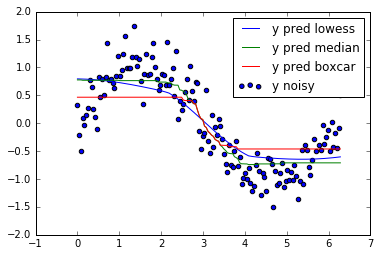

In [60]:
import math
n = 150
x = np.linspace(0, 2 * math.pi, n)
y = np.sin(x) + 0.3 * np.random.randn(n)

f = 0.7
yest_lowess = lowess(x, y, f=f, iter=3)
print(np.mean(np.abs(y-yest_lowess)))
yest = repeated_wgt_median(x, y, f=f)
print(np.mean(np.abs(y-yest)))
yest_boxcar = repeated_median(x, y, f=f)
print(np.mean(np.abs(y-yest_boxcar)))
%pylab inline
import pylab as pl
pl.clf()
pl.scatter(x, y, label='y noisy')
pl.plot(x, yest_lowess, label='y pred lowess')
pl.plot(x, yest, label='y pred median')
pl.plot(x, yest_boxcar, label='y pred boxcar')
pl.legend()
pl.show()